In [ ]:
import kagglehub

path = kagglehub.dataset_download("crowdflower/twitter-airline-sentiment")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/crowdflower/twitter-airline-sentiment/versions/4


In [ ]:
# 1. load required libraries
import re
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
color = sns.color_palette()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#2. read data from pandas
dataset = pd.read_csv("/root/.cache/kagglehub/datasets/crowdflower/twitter-airline-sentiment/versions/4/Tweets.csv")

In [ ]:
#3. check first few rows of dataset
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
#4. check size(row by column-wise) of data
dataset.shape

(14640, 15)

In [ ]:
#5. explore the type of columns in data
dataset.dtypes

,0
tweet_id,int64
airline_sentiment,object
airline_sentiment_confidence,float64
negativereason,object
negativereason_confidence,float64
airline,object
airline_sentiment_gold,object
name,object
negativereason_gold,object
retweet_count,int64


In [ ]:
#6. see amount of null values in each column
dataset.isnull().sum()

,0
tweet_id,0
airline_sentiment,0
airline_sentiment_confidence,0
negativereason,5462
negativereason_confidence,4118
airline,0
airline_sentiment_gold,14600
name,0
negativereason_gold,14608
retweet_count,0


In [ ]:
#7. exploring our target variable which is airline_sentiment
print(dataset["airline_sentiment"].value_counts() / dataset.shape[0])
print(dataset['airline_sentiment'])

airline_sentiment
negative    0.626913
neutral     0.211680
positive    0.161407
Name: count, dtype: float64
0         neutral
1        positive
2         neutral
3        negative
4        negative
           ...   
14635    positive
14636    negative
14637     neutral
14638    negative
14639     neutral
Name: airline_sentiment, Length: 14640, dtype: object


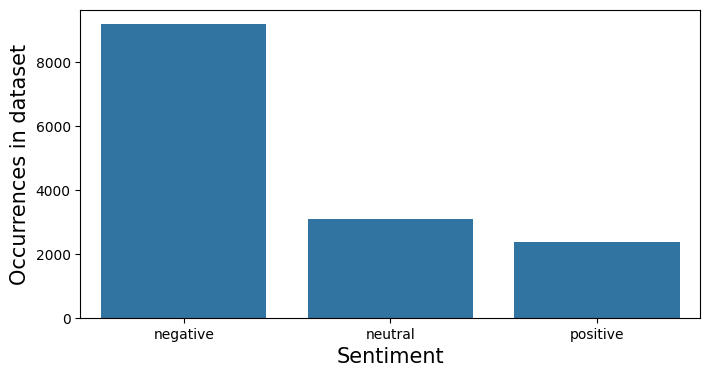

In [ ]:
#8. creating a bar plot for our classes.
count_sentiment = dataset["airline_sentiment"].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(y=count_sentiment.values, x=count_sentiment.index)
plt.ylabel('Occurrences in dataset', fontsize=15)
plt.xlabel('Sentiment', fontsize=15)
plt.show()

In [ ]:
#9. Extracting our working data column
# and renaming the text column of the dataframe to tweet
text_dataset = dataset[["text", "airline_sentiment"]]
text_dataset.columns = ["Tweet", "Sentiment"] #rename the columns
text_dataset.head()

,Tweet,Sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [ ]:
#10. Set of stop words in english
stops = set(stopwords.words("english"))
def clean_tweet(tweet):
  tweet = tweet.lower() # convert tweets to lower case
  tweet = " ".join(filter(lambda x:x[0]!='@', tweet.split())) # remove user ids from the tweet
  tweet = " ".join(filter(lambda x:x[0]!='#', tweet.split())) # remove hash tags from the tweet
  tweet = re.sub("[^a-zA-Z]+", " ", tweet) # keep only alphabets
  tweet = " ".join([w for w in tweet.split() if not w in stops]) # remove stop words
  return tweet

In [ ]:
#11. create new column in dataframe with cleaned tweets
text_dataset["Cleaned_Tweet"] = text_dataset["Tweet"].apply(clean_tweet)
text_dataset.head()

<ipython-input-12-8475e5ebfd60>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_dataset["Cleaned_Tweet"] = text_dataset["Tweet"].apply(clean_tweet)


,Tweet,Sentiment,Cleaned_Tweet
0,@VirginAmerica What @dhepburn said.,neutral,said
1,@VirginAmerica plus you've added commercials t...,positive,plus added commercials experience tacky
2,@VirginAmerica I didn't today... Must mean I n...,neutral,today must mean need take another trip
3,@VirginAmerica it's really aggressive to blast...,negative,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,negative,really big bad thing


In [ ]:
#12. function for n_grams
def find_ngrams(text, n):
  return list(itertools.combinations(text, n))

In [ ]:
#13. Create a empty dictionary container and
# function to populate the dictionary container
D = {}
def create_dict(row):
  value = 0
  if row["Sentiment"] == "positive":
    value = 1
  elif row["Sentiment"] == "negative":
    value = -1
  tweet = row["Cleaned_Tweet"]
  tweet = tweet.split()
  ngrams = []
  for i in range(1,4):
    ngrams = ngrams + find_ngrams(tweet, i)
  ngrams = [" ".join(i) for i in ngrams]
  for gram in ngrams:
    if gram in D:
      D[gram] += value
    else:
      D[gram] = value


In [ ]:
#14. Split our dataset into train and test.
train_data, test_data = train_test_split(text_dataset, test_size = 0.2,
                                         random_state = 82,
                                         stratify = text_dataset["Sentiment"])
print (train_data.shape)
print (test_data.shape)

(11712, 3)
(2928, 3)


In [ ]:
#15. Creating a dictionary.
_ = train_data.apply(create_dict, axis = 1)
print(len(D))
print(dict(list(D.items())[0:20]))

1777160
{'airport': -344, 'snow': -24, 'removal': 8, 'method': 6, 'keep': -92, 'good': -48, 'work': -188, 'folks': -14, 'cessna': 8, 'become': -2, 'http': -292, 'co': -308, 'v': -10, 'tmusjvu': 2, 'airport snow': 8, 'airport removal': 8, 'airport method': 8, 'airport keep': 8, 'airport good': 2, 'airport work': 6}


In [ ]:
#16. Creating a Rule Based Classifier
#Rule based function to predict sentiment
def predict_sentiment(tweet):
  tweet = tweet.split()
  ngrams = []
  for i in range(1,4):
    ngrams = ngrams + find_ngrams(tweet, i)
  ngrams = [" ".join(i) for i in ngrams]
  s = 0
  for gram in ngrams:
    if gram in D:
      value = D[gram]
      if value < 0:
        s -= 1
      elif value > 0:
        s += 1
  if s < 0:
    return "negative"
  elif s > 0:
    return "positive"
  else:
    return "neutral"


In [ ]:
#17. Predicting on test data
#predict sentiment on test data
test_data["prediction"] = test_data["Cleaned_Tweet"].apply(predict_sentiment)
test_data.head()

,Tweet,Sentiment,Cleaned_Tweet,prediction
7545,@JetBlue what happened to our plane meant to l...,negative,happened plane meant leave wait buffalo seems ...,negative
5902,"“@SouthwestAir: #IfThe80sNeverStopped, we'd st...",neutral,southwestair still rocking chart topping hit,negative
13224,@AmericanAir Ok. We will probably Cancelled Fl...,negative,ok probably cancelled flight flights take refu...,negative
3240,@united Am I illiterate or is there a magic co...,negative,illiterate magic code make customer service si...,negative
1031,"@united @FlyEIA yes, they said it took more th...",negative,yes said took hour,negative


In [ ]:
#18. Compute model prediction accuracy
print("Accuracy on test set: {0:.2f}%"
.format(accuracy_score(test_data["Sentiment"],
test_data["prediction"])*100))

Accuracy on test set: 66.67%


In [ ]:
#19. Exploring the prediction distribution percentage
print(test_data["prediction"].value_counts()/test_data.shape[0])
print(test_data["Sentiment"].value_counts()/test_data.shape[0])

prediction
negative    0.928279
positive    0.051571
neutral     0.020150
Name: count, dtype: float64
Sentiment
negative    0.626708
neutral     0.211749
positive    0.161544
Name: count, dtype: float64


Confusion matrix, without normalization


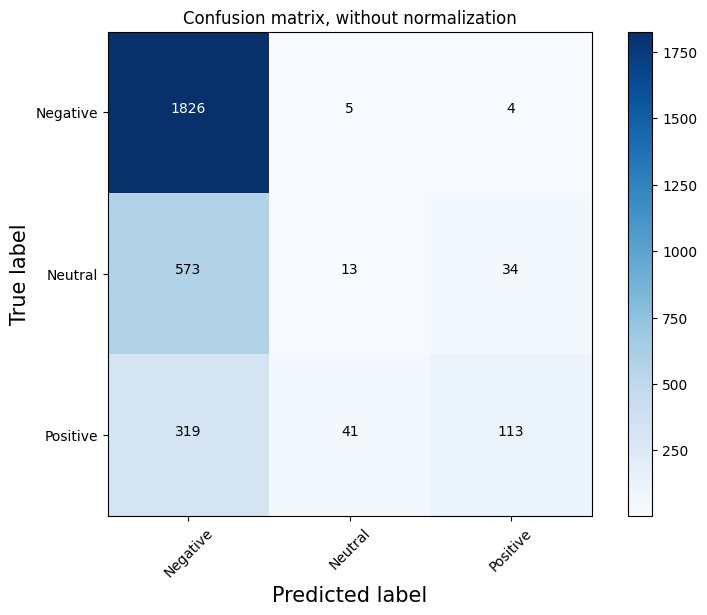

In [ ]:
#20. Confusion matrix to check the correctness of our
# classification algorithm
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')
  #print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                                plt.text(j, i, format(cm[i, j], fmt),
                                horizontalalignment="center",
                                color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label',fontsize=15)
  plt.xlabel('Predicted label',fontsize=15)
  plt.show()
cnf_matrix = confusion_matrix(test_data["Sentiment"], test_data["prediction"])
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'],
title='Confusion matrix, without normalization')

Normalized confusion matrix


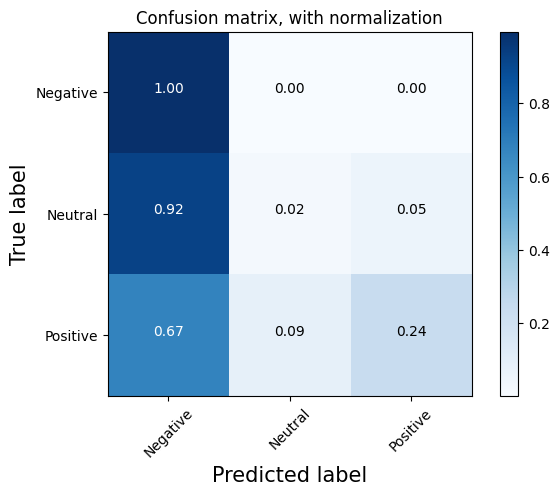

In [ ]:
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'],
title='Confusion matrix, with normalization', normalize=True)